<a href="https://colab.research.google.com/github/hedayet13/learning-tensorflow/blob/main/transfer_learning_in_tensorflow_feature_extraction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!nvidia-smi


Sun Jul 18 06:13:24 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.42.01    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   37C    P8     9W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [2]:
import zipfile

!wget https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip

#unzipping

zip_ref = zipfile.ZipFile("10_food_classes_10_percent.zip")
zip_ref.extractall()
zip_ref.close()

--2021-07-18 06:13:24--  https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 173.194.202.128, 74.125.20.128, 74.125.142.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|173.194.202.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 168546183 (161M) [application/zip]
Saving to: ‘10_food_classes_10_percent.zip’

10_food_classes_10_ 100%[===================>] 160.74M   178MB/s    in 0.9s    

2021-07-18 06:13:25 (178 MB/s) - ‘10_food_classes_10_percent.zip’ saved [168546183/168546183]



In [3]:
import os 

for dirpath,dirnames,filenames in os.walk("10_food_classes_10_percent"):
  print(f"There are {len(dirnames)} directories and {len(filenames)} images in '{dirpath}'.")

There are 2 directories and 0 images in '10_food_classes_10_percent'.
There are 10 directories and 0 images in '10_food_classes_10_percent/test'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/hamburger'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/grilled_salmon'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/pizza'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/chicken_curry'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/sushi'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/ice_cream'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/fried_rice'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/chicken_wings'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/steak'.
There are 0 directories and 250 images in '10_food_classes_10_percent

In [4]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

IMAGE_SHAPE =(224,224)
BATCH_SIZE = 32

train_dir = "10_food_classes_10_percent/train"
test_dir = "10_food_classes_10_percent/test"

train_datagen = ImageDataGenerator(rescale = 1/255.)
test_datagen= ImageDataGenerator(rescale=1/255.)

print("training Images:")

train_data_10_percent= train_datagen.flow_from_directory(train_dir,
                                                         target_size =IMAGE_SHAPE,
                                                         batch_size = BATCH_SIZE,
                                                         class_mode ="categorical")

print("testing Images")
test_data = test_datagen.flow_from_directory(test_dir,
                                             target_size= IMAGE_SHAPE,
                                             batch_size = BATCH_SIZE,
                                             class_mode = "categorical")

training Images:
Found 750 images belonging to 10 classes.
testing Images
Found 2500 images belonging to 10 classes.


In [18]:
##setting up callback

# Tensorboard callback

import datetime
def create_tensorboard_callback(dir_name, experiment_name):
  log_dir = dir_name + "/" + experiment_name + "/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
  tensorboard_callback = tf.keras.callbacks.TensorBoard(
      log_dir=log_dir
  )
  print(f"Saving TensorBoard log files to: {log_dir}")
  return tensorboard_callback

In [19]:
resnet_url ='https://tfhub.dev/google/imagenet/resnet_v2_50/feature_vector/5'

efficientnet_url = 'https://tfhub.dev/tensorflow/efficientnet/b0/feature-vector/1'

In [20]:
import tensorflow as tf
import tensorflow_hub as hub
from tensorflow.keras import layers

In [21]:
def create_model(model_url,num_classes = 10):
  feature_extractor_layer = hub.KerasLayer(model_url,
                                           trainable=False,
                                           name = "Feature_extraction_layer",
                                           input_shape = IMAGE_SHAPE+(3,))
  model = tf.keras.Sequential(
      [
       feature_extractor_layer,
       tf.keras.layers.Dense(num_classes,activation = "softmax",name="output_layer")
      ]
  )
  return model

In [22]:
resnet_model = create_model(model_url=resnet_url,
                            num_classes = train_data_10_percent.num_classes)

In [23]:
resnet_model.compile(
    loss ="categorical_crossentropy",
    optimizer = tf.keras.optimizers.Adam(),
    metrics = ["accuracy"]
)

In [24]:
resnet_history = resnet_model.fit(train_data_10_percent,
                           epochs = 5,
                           steps_per_epoch = len(train_data_10_percent),
                           validation_data = test_data,
                           validation_steps = len(test_data),
                           callbacks = [create_tensorboard_callback(dir_name="tensorflow_hub",
                                                                    experiment_name = "resnet50v2")])

Saving TensorBoard log files to: tensorflow_hub/resnet50v2/20210718-062353
Epoch 1/5
24/24 [==============================] - 52s 827ms/step - loss: 1.7536 - accuracy: 0.3947 - val_loss: 1.1257 - val_accuracy: 0.6364
Epoch 2/5
24/24 [==============================] - 16s 680ms/step - loss: 0.8460 - accuracy: 0.7533 - val_loss: 0.7997 - val_accuracy: 0.7424
Epoch 3/5
24/24 [==============================] - 15s 663ms/step - loss: 0.6026 - accuracy: 0.8347 - val_loss: 0.7166 - val_accuracy: 0.7676
Epoch 4/5
24/24 [==============================] - 15s 662ms/step - loss: 0.4646 - accuracy: 0.8760 - val_loss: 0.6833 - val_accuracy: 0.7748
Epoch 5/5
24/24 [==============================] - 16s 693ms/step - loss: 0.3708 - accuracy: 0.9160 - val_loss: 0.6505 - val_accuracy: 0.7852


In [25]:
resnet_model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Feature_extraction_layer (Ke (None, 2048)              23564800  
_________________________________________________________________
output_layer (Dense)         (None, 10)                20490     
Total params: 23,585,290
Trainable params: 20,490
Non-trainable params: 23,564,800
_________________________________________________________________


In [26]:
resnet_history.history

{'accuracy': [0.3946666717529297,
  0.753333330154419,
  0.8346666693687439,
  0.8759999871253967,
  0.9160000085830688],
 'loss': [1.7535721063613892,
  0.8459942936897278,
  0.6026466488838196,
  0.4645884335041046,
  0.37079861760139465],
 'val_accuracy': [0.6363999843597412,
  0.7423999905586243,
  0.7675999999046326,
  0.7748000025749207,
  0.7851999998092651],
 'val_loss': [1.1256757974624634,
  0.7997221946716309,
  0.7166278958320618,
  0.6832528114318848,
  0.650473415851593]}

In [32]:
import matplotlib.pyplot as plt

def plot_loss_curve(history):

  loss =history.history["loss"]
  val_loss = history.history["val_loss"]
  accuracy =history.history["accuracy"]
  val_accuracy = history.history["val_accuracy"]

  epochs = range(len(history.history["loss"]))

  plt.plot(epochs,loss,label = "training loss")
  plt.plot(epochs,val_loss,label = "val loss")
  plt.legend()

  plt.figure()

  plt.plot(epochs,accuracy,label = "accuracy")
  plt.plot(epochs,val_accuracy,label = "val_accuracy")
  plt.legend()

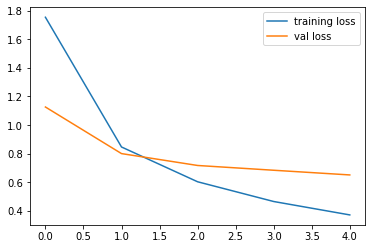

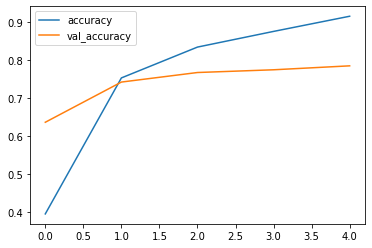

In [33]:
plot_loss_curve(resnet_history)

In [36]:
efficientnet_model = create_model(model_url=efficientnet_url,
                                  num_classes=train_data_10_percent.num_classes)

In [38]:
efficientnet_model.compile(
    loss= 'categorical_crossentropy',
    optimizer = tf.keras.optimizers.Adam(),
    metrics = ["accuracy"]
)

In [45]:
efficientnet_history = efficientnet_model.fit(train_data_10_percent,
                                              epochs = 10,
                                              steps_per_epoch= len(train_data_10_percent),
                                              validation_data = test_data,
                                              validation_steps = len(test_data),
                                              callbacks = [create_tensorboard_callback(dir_name="tensorflow_hub",
                                                                                       experiment_name = "efficientnetB0")])

Saving TensorBoard log files to: tensorflow_hub/efficientnetB0/20210718-065735
Epoch 1/10
24/24 [==============================] - 17s 742ms/step - loss: 0.4578 - accuracy: 0.9107 - val_loss: 0.5306 - val_accuracy: 0.8688
Epoch 2/10
24/24 [==============================] - 15s 634ms/step - loss: 0.4017 - accuracy: 0.9267 - val_loss: 0.5013 - val_accuracy: 0.8732
Epoch 3/10
24/24 [==============================] - 15s 633ms/step - loss: 0.3595 - accuracy: 0.9333 - val_loss: 0.4798 - val_accuracy: 0.8712
Epoch 4/10
24/24 [==============================] - 15s 628ms/step - loss: 0.3213 - accuracy: 0.9440 - val_loss: 0.4636 - val_accuracy: 0.8732
Epoch 5/10
24/24 [==============================] - 15s 665ms/step - loss: 0.2905 - accuracy: 0.9547 - val_loss: 0.4506 - val_accuracy: 0.8736
Epoch 6/10
24/24 [==============================] - 15s 652ms/step - loss: 0.2640 - accuracy: 0.9587 - val_loss: 0.4399 - val_accuracy: 0.8744
Epoch 7/10
24/24 [==============================] - 16s 669ms/s

In [43]:
efficientnet_model.evaluate(test_data)

79/79 [==============================] - 12s 156ms/step - loss: 0.5687 - accuracy: 0.8640


[0.5686935782432556, 0.8640000224113464]

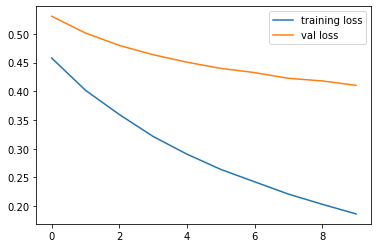

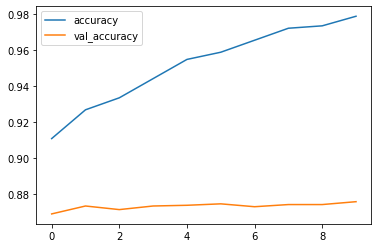

In [48]:
plot_loss_curve(efficientnet_history)

In [46]:
efficientnet_model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Feature_extraction_layer (Ke (None, 1280)              4049564   
_________________________________________________________________
output_layer (Dense)         (None, 10)                12810     
Total params: 4,062,374
Trainable params: 12,810
Non-trainable params: 4,049,564
_________________________________________________________________


In [47]:
resnet_model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Feature_extraction_layer (Ke (None, 2048)              23564800  
_________________________________________________________________
output_layer (Dense)         (None, 10)                20490     
Total params: 23,585,290
Trainable params: 20,490
Non-trainable params: 23,564,800
_________________________________________________________________


In [52]:
!tensorboard dev upload --logdir ./tensorflow_hub/ \
  --name "EfficientNetB0 vs. ResNet50V2" \
  --description "comparing two different tf hub" \
  --one_shot

2021-07-18 07:25:30.451760: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcudart.so.11.0

***** TensorBoard Uploader *****

This will upload your TensorBoard logs to https://tensorboard.dev/ from
the following directory:

./tensorflow_hub/

This TensorBoard will be visible to everyone. Do not upload sensitive
data.

Your use of this service is subject to Google's Terms of Service
<https://policies.google.com/terms> and Privacy Policy
<https://policies.google.com/privacy>, and TensorBoard.dev's Terms of Service
<https://tensorboard.dev/policy/terms/>.

This notice will not be shown again while you are logged into the uploader.
To log out, run `tensorboard dev auth revoke`.

Continue? (yes/NO) yes

Please visit this URL to authorize this application: https://accounts.google.com/o/oauth2/auth?response_type=code&client_id=373649185512-8v619h5kft38l4456nm2dj4ubeqsrvh6.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2

In [54]:
#public tensorboard view 
# https://tensorboard.dev/experiment/YoXnjyoSQlGQBN15WmuGxA/

In [55]:
!tensorboard dev list

2021-07-18 07:30:28.752370: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcudart.so.11.0
Data for the "text" plugin is now uploaded to TensorBoard.dev! Note that uploaded data is public. If you do not want to upload data for this plugin, use the "--plugins" command line argument.
https://tensorboard.dev/experiment/YoXnjyoSQlGQBN15WmuGxA/
	Name                 EfficientNetB0 vs. ResNet50V2
	Description          comparing two different tf hub
	Id                   YoXnjyoSQlGQBN15WmuGxA
	Created              2021-07-18 07:26:24 (4 minutes ago)
	Updated              2021-07-18 07:26:28 (4 minutes ago)
	Runs                 6
	Tags                 5
	Scalars              120
	Tensor bytes         0
	Binary object bytes  10149335
Total: 1 experiment(s)
